# Automatic program Repair (APR)

In [1]:
import sys

import os

sys.path.append(os.path.abspath(os.path.join("..")))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from data_loader.loader import load_buggy_dataset, load_data
from bug_detective.detective import process_prompt_dataset

# Add the data_loader module to the path

# Import data loader functions

# Load sample train data
print("Loading sample train data...")

# Load buggy train dataset
buggy_train_df = load_buggy_dataset("train")

Loading sample train data...


In [13]:
# Create a unique ID based on function_name, filename, and url
buggy_train_df["id"] = buggy_train_df.apply(
    lambda row: hash((row["function_name"], row["filename"], row["url"])), axis=1
)

# Convert to string and ensure uniqueness
buggy_train_df["id"] = buggy_train_df["id"].astype(str)

print(f"Created unique ID column. Shape: {buggy_train_df.shape}")
print(f"Number of unique IDs: {buggy_train_df['id'].nunique()}")
print(f"Total rows: {len(buggy_train_df)}")

Created unique ID column. Shape: (14118, 17)
Number of unique IDs: 13777
Total rows: 14118


In [37]:
# Check for rows with repeating id column
duplicate_ids = buggy_train_df[buggy_train_df.duplicated(subset=["id"], keep=False)]
print(f"Found {len(duplicate_ids)} rows with duplicate IDs")
print(f"Number of unique duplicate IDs: {duplicate_ids['id'].nunique()}")

# Display the first few rows with duplicate IDs
test_df = duplicate_ids[duplicate_ids["id"] == "3327769774376610081"]

Found 666 rows with duplicate IDs
Number of unique duplicate IDs: 325


In [36]:
# duplicate_ids['id'].tolist()

In [38]:
print(test_df["before_merge_without_docstrings"].iloc[0])

    def append_header(self, name, value):
        
        name, value = self._encode_header(name, value)

        name = name.lower()
        if name in self._headers:
            value = self._headers[name] + ',' + value

        self._headers[name] = value


In [39]:
print(test_df["before_merge_without_docstrings"].iloc[1])

    def append_header(self, name, value):
        
        name = name.lower()
        if name in self._headers:
            value = self._headers[name] + ',' + value

        self._headers[name] = value


In [32]:
test_df.drop_duplicates(subset=["before_merge_without_docstrings"], keep="first")

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,id
32216,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",falcon/response.py,"# Copyright 2013 by Rackspace Hosting, Inc.\n#...","# Copyright 2013 by Rackspace Hosting, Inc.\n#...",Response.set_header,https://github.com/falconry/falcon/issues/413,"[{'piece_type': 'source code', 'piece_content'...","Traceback (most recent call last):\nFile ""/Use...",TypeError,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",[],[],buggy_snippets_files/45e17bd16b067d758a86afae6...,buggy_snippets_files/45e17bd16b067d758a86afae6...,3947334195646986454
32232,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",falcon/response.py,"# Copyright 2013 by Rackspace Hosting, Inc.\n#...","# Copyright 2013 by Rackspace Hosting, Inc.\n#...",Response.set_header,https://github.com/falconry/falcon/issues/413,"[{'piece_type': 'source code', 'piece_content'...","Traceback (most recent call last):\nFile ""/Use...",TypeError,"def set_header(self, name, value):\n ...","def set_header(self, name, value):\n ...",[],[],buggy_snippets_files/cd2538f03b06aec1ebbed2243...,buggy_snippets_files/cd2538f03b06aec1ebbed2243...,3947334195646986454


In [2]:
sample_data = buggy_train_df.sample(n=100, random_state=0)
# sample_data = load_data("data_20250703_235942.pkl")
print(f"Sample data shape: {sample_data.shape}")
print(f"Sample data columns: {sample_data.columns.tolist()}")

Sample data shape: (100, 16)
Sample data columns: ['after_merge', 'before_merge', 'filename', 'full_file_code_after_merge', 'full_file_code_before_merge', 'function_name', 'url', 'source code and errors', 'full_traceback', 'traceback_type', 'before_merge_without_docstrings', 'after_merge_without_docstrings', 'before_merge_docstrings', 'after_merge_docstrings', 'path_to_snippet_before_merge', 'path_to_snippet_after_merge']


In [3]:
# Rename the column from qwen_output to response_qwen-2.5-coder-32b-instruct
sample_data = sample_data.rename(
    columns={"qwen_output": "response_qwen-2.5-coder-32b-instruct"}
)
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...


In [6]:
from llm_models.open_router import create_openrouter_model

qwen_model = create_openrouter_model(
    model_name="qwen/qwen-2.5-coder-32b-instruct", temperature=0.0, max_tokens=1000
)
gpt_4o_mini_model = create_openrouter_model(
    model_name="openai/gpt-4o-mini", temperature=0.0, max_tokens=1000
)

In [7]:
# outputs_qwen = await process_prompt_dataset(qwen_model, sample_data)
# sample_data['response_qwen-2.5-coder-32b-instruct'] = outputs_qwen

outputs_gpt_4o_mini = await process_prompt_dataset(gpt_4o_mini_model, sample_data)
sample_data["response_gpt-4o-mini"] = outputs_gpt_4o_mini

Processing sample 100/100: 100%|█████████████████████████████| 100/100 [07:46<00:00,  4.66s/samples]


In [8]:
sample_data.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct,response_gpt-4o-mini
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...,"async def stop_notify(self, _uuid: str) -> Non...","async def stop_notify(self, _uuid: str) -> Non..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,"def inner(df, func, *args, **kwargs):\n ...","def inner(df, func, *args, **kwargs):\n """"""..."
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...,"def post(self, url, data, timeout=None):\n ...","def post(self, url, data, timeout=None):\n ..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,def __init__(self):\n app.Canvas.__init__(s...,self.program['a_position'] = y.ravel().reshape...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,"def load(tag, creds=None, session_creds=True) ...","def load(tag, 

In [10]:
import pickle
import pandas as pd
from datetime import datetime
from pathlib import Path
import os

data_path = "/Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
file_name = f"data_{timestamp}"
file_name += ".pkl"
file_path = os.path.join(data_path, file_name)
Path(data_path).mkdir(parents=True, exist_ok=True)
with open(file_path, "wb") as f:
    pickle.dump(sample_data, f)
print(f"Data saved to: {file_path}")

Data saved to: /Users/zanchitta/Developer/BugDetectiveAI/Bugdetectiveai/data/checkpoints/data_20250706_152806.pkl


In [21]:
from utils.simple_metrics import diff_score, codebleu


def compare_metrics_versus_bug_histograms(
    buggy_codes, groundtruth_codes, corrected_codes
):
    """Compare metrics between buggy, corrected, and groundtruth codes using histograms."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate diff scores (returns dict with all metrics)
    bug_vs_corrected_diff = [
        diff_score(bug, corr) for bug, corr in zip(buggy_codes, corrected_codes)
    ]
    bug_vs_groundtruth_diff = [
        diff_score(bug, gt) for bug, gt in zip(buggy_codes, groundtruth_codes)
    ]

    # Get all available metrics from the first result to determine what's available
    available_metrics = list(bug_vs_corrected_diff[0].keys())

    # Extract all metric components dynamically
    bug_vs_corrected_metrics = {}
    bug_vs_groundtruth_metrics = {}

    for metric in available_metrics:
        bug_vs_corrected_metrics[metric] = [d[metric] for d in bug_vs_corrected_diff]
        bug_vs_groundtruth_metrics[metric] = [
            d[metric] for d in bug_vs_groundtruth_diff
        ]

    # Calculate number of rows and columns for subplots
    n_metrics = len(available_metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Create histograms for each metric
    for i, metric in enumerate(available_metrics):
        row = i // n_cols
        col = i % n_cols

        axes[row, col].hist(
            bug_vs_corrected_metrics[metric],
            bins=20,
            alpha=0.7,
            label="Bug vs Corrected",
            color="red",
        )
        axes[row, col].hist(
            bug_vs_groundtruth_metrics[metric],
            bins=20,
            alpha=0.7,
            label="Bug vs Groundtruth",
            color="blue",
        )
        axes[row, col].set_xlabel(metric.replace("_", " ").title())
        axes[row, col].set_ylabel("Frequency")
        axes[row, col].set_title(f"{metric.replace('_', ' ').title()} Comparison")
        axes[row, col].legend()

    # Hide empty subplots
    for i in range(n_metrics, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print summary statistics for all metrics
    print("=== ALL METRICS STATISTICS ===")
    for metric in available_metrics:
        print(
            f"{metric.replace('_', ' ').title()} - Bug vs Corrected: "
            f"mean={np.mean(bug_vs_corrected_metrics[metric]):.3f}, "
            f"std={np.std(bug_vs_corrected_metrics[metric]):.3f}"
        )
        print(
            f"{metric.replace('_', ' ').title()} - Bug vs Groundtruth: "
            f"mean={np.mean(bug_vs_groundtruth_metrics[metric]):.3f}, "
            f"std={np.std(bug_vs_groundtruth_metrics[metric]):.3f}"
        )
        print()


def compare_groundtruth_vs_corrected_histograms(groundtruth_codes, corrected_codes):
    """Compare metrics between groundtruth and corrected codes using histograms."""
    import matplotlib.pyplot as plt
    import numpy as np

    # Calculate diff scores (returns dict with all metrics)
    groundtruth_vs_corrected_diff = [
        diff_score(gt, corr) for gt, corr in zip(groundtruth_codes, corrected_codes)
    ]

    # Get all available metrics from the first result to determine what's available
    available_metrics = list(groundtruth_vs_corrected_diff[0].keys())

    # Extract all metric components dynamically
    groundtruth_vs_corrected_metrics = {}

    for metric in available_metrics:
        groundtruth_vs_corrected_metrics[metric] = [
            d[metric] for d in groundtruth_vs_corrected_diff
        ]

    # Calculate number of rows and columns for subplots
    n_metrics = len(available_metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols  # Ceiling division

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)

    # Create histograms for each metric
    for i, metric in enumerate(available_metrics):
        row = i // n_cols
        col = i % n_cols

        axes[row, col].hist(
            groundtruth_vs_corrected_metrics[metric],
            bins=20,
            alpha=0.7,
            label="Groundtruth vs Corrected",
            color="green",
        )
        axes[row, col].set_xlabel(metric.replace("_", " ").title())
        axes[row, col].set_ylabel("Frequency")
        axes[row, col].set_title(f"{metric.replace('_', ' ').title()} Comparison")
        axes[row, col].legend()

    # Hide empty subplots
    for i in range(n_metrics, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Print summary statistics for all metrics
    print("=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===")
    for metric in available_metrics:
        print(
            f"{metric.replace('_', ' ').title()} - Groundtruth vs Corrected: "
            f"mean={np.mean(groundtruth_vs_corrected_metrics[metric]):.3f}, "
            f"std={np.std(groundtruth_vs_corrected_metrics[metric]):.3f}"
        )
        print()

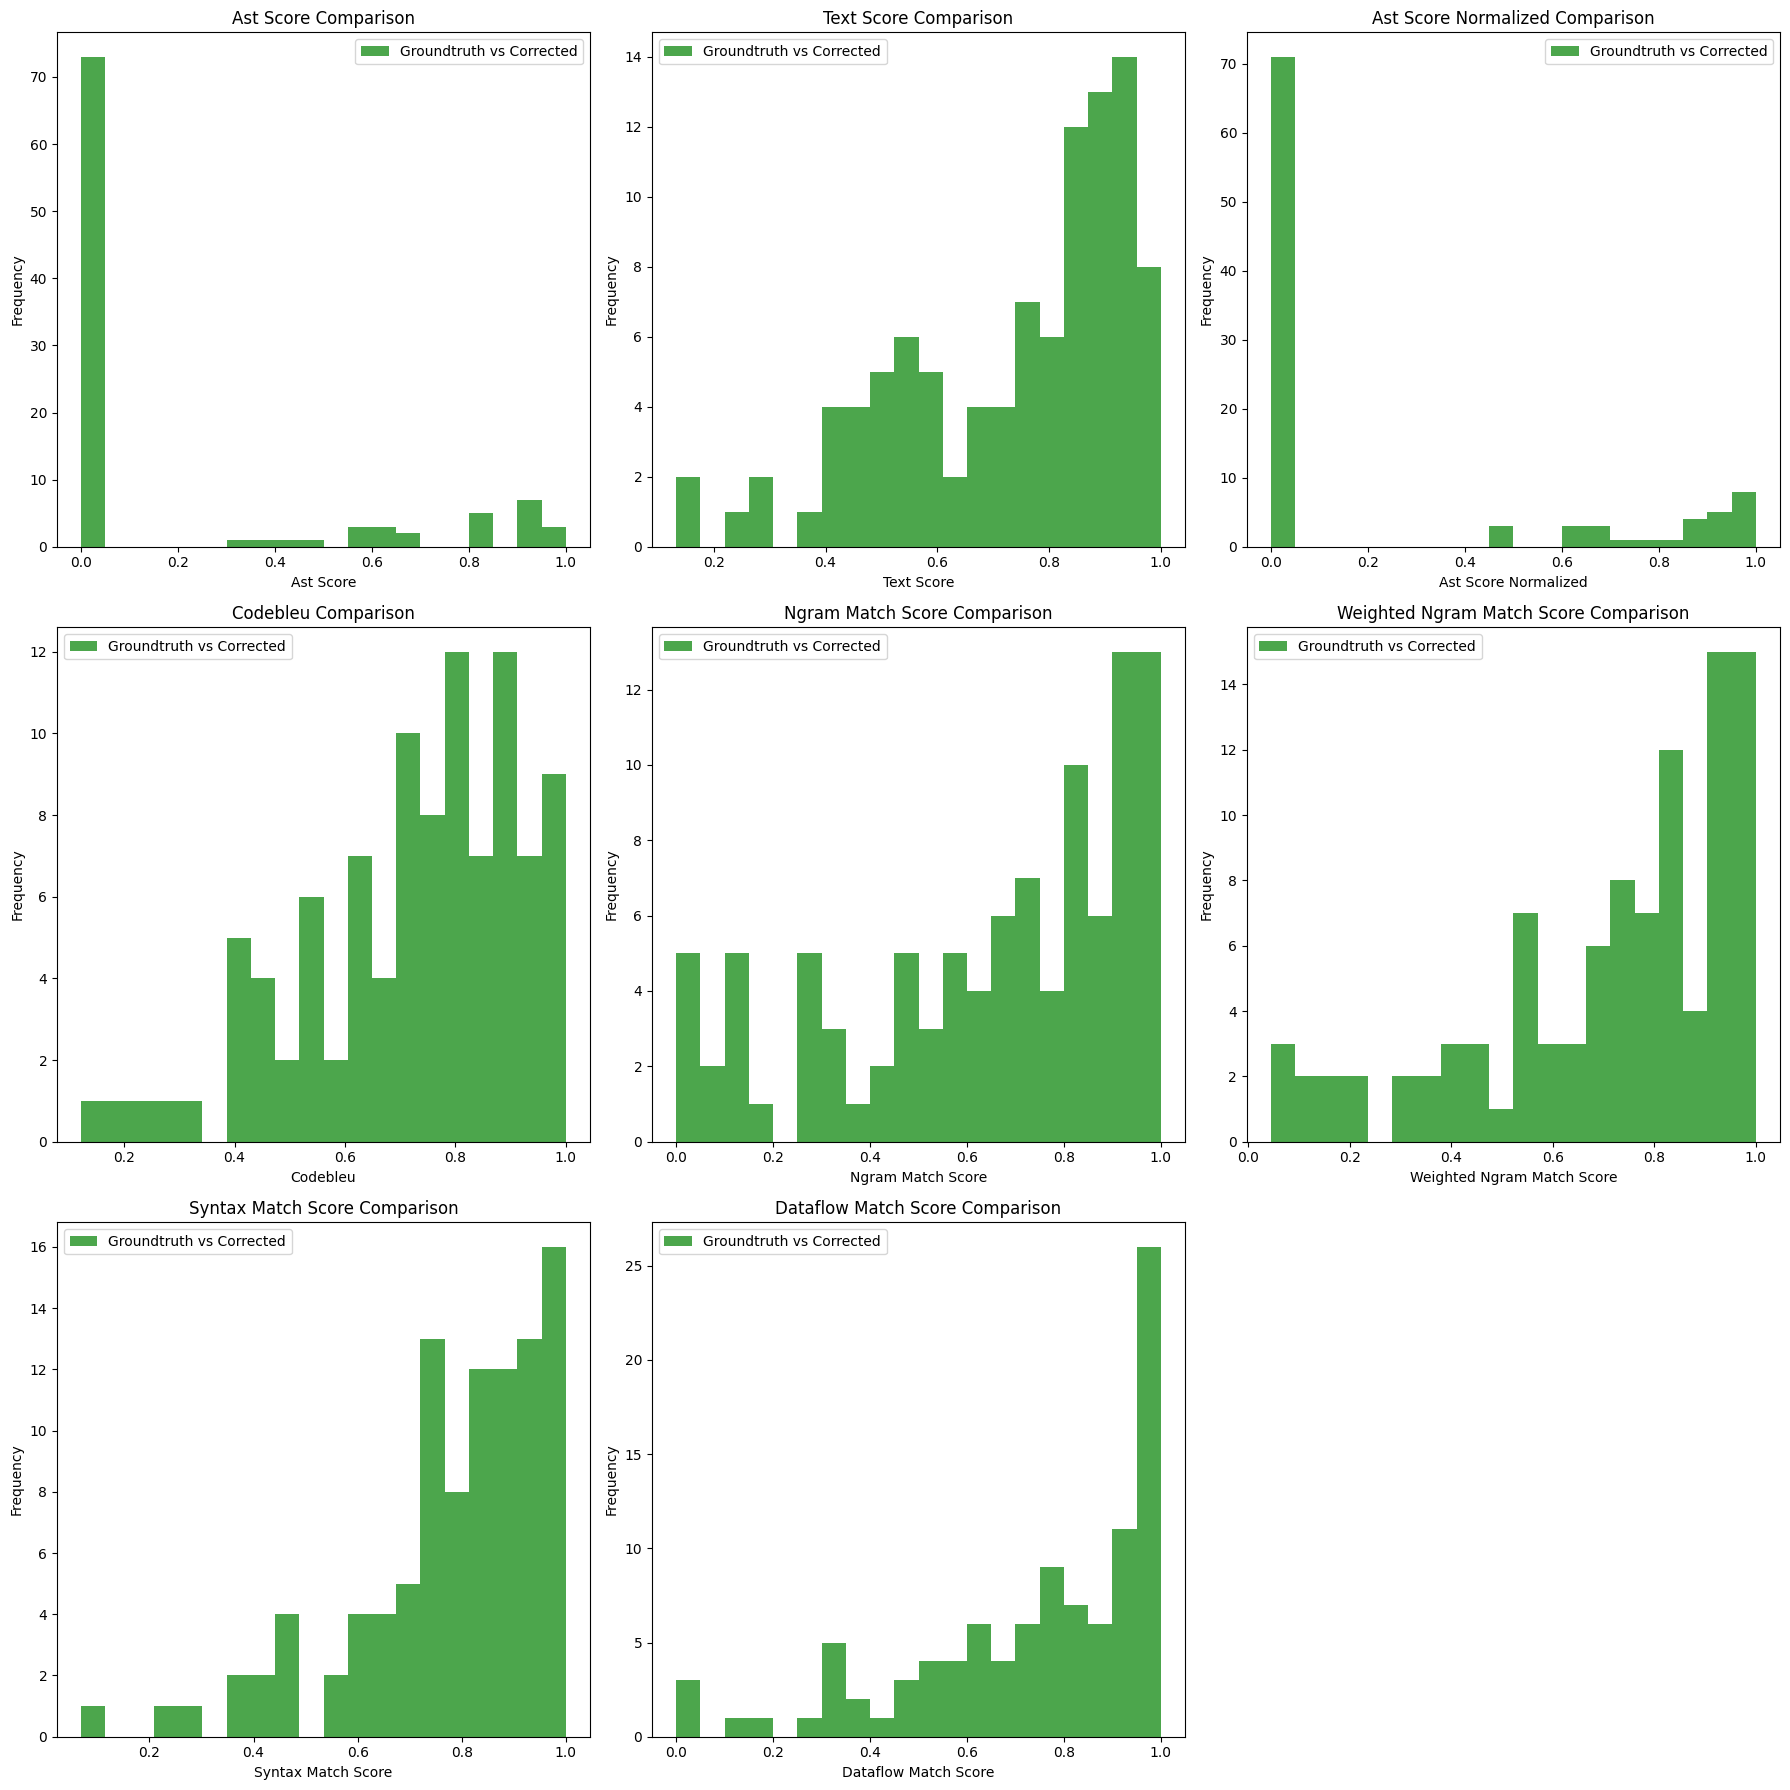

=== GROUNDTRUTH VS CORRECTED METRICS STATISTICS ===
Ast Score - Groundtruth vs Corrected: mean=0.201, std=0.346

Text Score - Groundtruth vs Corrected: mean=0.734, std=0.208

Ast Score Normalized - Groundtruth vs Corrected: mean=0.237, std=0.382

Codebleu - Groundtruth vs Corrected: mean=0.725, std=0.199

Ngram Match Score - Groundtruth vs Corrected: mean=0.644, std=0.298

Weighted Ngram Match Score - Groundtruth vs Corrected: mean=0.706, std=0.258

Syntax Match Score - Groundtruth vs Corrected: mean=0.783, std=0.189

Dataflow Match Score - Groundtruth vs Corrected: mean=0.739, std=0.256



In [22]:
compare_groundtruth_vs_corrected_histograms(
    sample_data["after_merge"], sample_data["response_qwen-2.5-coder-32b-instruct"]
)

In [ ]:
# Call the function with the lists
compare_metrics_versus_bug_histograms(
    sample_data["before_merge"],
    sample_data["after_merge"],
    sample_data["response_qwen-2.5-coder-32b-instruct"],
)

In [10]:
codebleu_scores = codebleu(
    sample_data["before_merge"].tolist(), sample_data["after_merge"].tolist()
)
print(codebleu_scores)

{'codebleu': 0.8869282094221181, 'ngram_match_score': 0.8967145130610161, 'weighted_ngram_match_score': 0.8972927314768683, 'syntax_match_score': 0.9057125307125307, 'dataflow_match_score': 0.8479930624380575}


In [41]:
check = load_data("data_20250705_180849.pkl")
check.head()

,after_merge,before_merge,filename,full_file_code_after_merge,full_file_code_before_merge,function_name,url,source code and errors,full_traceback,traceback_type,before_merge_without_docstrings,after_merge_without_docstrings,before_merge_docstrings,after_merge_docstrings,path_to_snippet_before_merge,path_to_snippet_after_merge,response_qwen-2.5-coder-32b-instruct
610334,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",bleak/backends/bluezdbus/client.py,# -*- coding: utf-8 -*-\nimport logging\nimpor...,# -*- coding: utf-8 -*-\nimport logging\nimpor...,BleakClientBlueZDBus.stop_notify,https://github.com/hbldh/bleak/issues/55,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""/hom...",bleak.exc.BleakError,"async def stop_notify(self, _uuid: str) ->...","async def stop_notify(self, _uuid: str) ->...",[],[],buggy_snippets_files/d534f47d51c12cba5c48476b2...,buggy_snippets_files/d534f47d51c12cba5c48476b2...,"async def stop_notify(self, _uuid: str) -> Non..."
455757,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",tqdm/std.py,"""""""\nCustomisable progressbar decorator for it...","""""""\nCustomisable progressbar decorator for it...",inner_generator.inner,https://github.com/tqdm/tqdm/issues/862,"[{'piece_type': 'source code', 'piece_content'...",----------------------------------------------...,TypeError,"def inner(df, func, *args, **kwarg...","def inner(df, func, *args, **kwarg...",[],[],buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,buggy_snippets_files/3417ddfddae8a2c9079a6fa9a...,"def inner(df, func, *args, **kwargs):\n ..."
564051,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",telegram/utils/request.py,#!/usr/bin/env python\n#\n# A library that pro...,#!/usr/bin/env python\n#\n# A library that pro...,Request.post,https://github.com/python-telegram-bot/python-...,"[{'piece_type': 'other', 'piece_content': 'fro...","Traceback (most recent call last):\nFile ""/tmp...",telegram.vendor.ptb_urllib3.urllib3.exceptions...,"def post(self, url, data, timeout=None):\n...","def post(self, url, data, timeout=None):\n...",[],[],buggy_snippets_files/6c268a7167cd7c7691093e131...,buggy_snippets_files/6c268a7167cd7c7691093e131...,"def post(self, url, data, timeout=None):\n ..."
47137,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,examples/demo/gloo/realtime_signals.py,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,#!/usr/bin/env python\n# -*- coding: utf-8 -*-...,Canvas.__init__,https://github.com/vispy/vispy/issues/528,"[{'piece_type': 'error message', 'piece_conten...",cyrille@Cyrille-ASUS:~/git/vispy/examples/demo...,IndexError,def __init__(self):\n app.Canvas.__...,def __init__(self):\n app.Canvas.__...,[],[],buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,buggy_snippets_files/fabf4d259a2e8f6c0999e17b2...,def __init__(self):\n app.Canvas.__init__(s...
30127,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",hub/collections/dataset/core.py,from collections import abc\nfrom configparser...,from collections import abc\nfrom configparser...,load,https://github.com/activeloopai/Hub/issues/216,"[{'piece_type': 'error message', 'piece_conten...","Traceback (most recent call last):\nFile ""hub/...",ValueError,"def load(tag, creds=None, session_creds=True) ...","def load(tag, creds=None, session_creds=True) ...",[Load a dataset from repository using given ur...,[Load a dataset from repository using given ur...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,buggy_snippets_files/c845cb26b5529e8f97a96c5cc...,"def load(tag, creds=None, session_creds=True) ..."


In [16]:
print(sample_data["before_merge"].iloc[0])

    async def stop_notify(self, _uuid: str) -> None:
        """Stops a notification session from a characteristic.

        Args:
            _uuid (str or uuid.UUID): The UUID of the characteristic to stop
            subscribing to notifications from.

        """
        char_props = self.characteristics.get(_uuid)
        await self._bus.callRemote(
            char_props.get("Path"),
            "StopNotify",
            interface=defs.GATT_CHARACTERISTIC_INTERFACE,
            destination=defs.BLUEZ_SERVICE,
            signature="",
            body=[],
            returnSignature="",
        ).asFuture(self.loop)
        self._notification_callbacks.pop(char_props.get("Path"), None)


In [17]:
print(sample_data["after_merge"].iloc[0])

    async def stop_notify(self, _uuid: str) -> None:
        """Stops a notification session from a characteristic.

        Args:
            _uuid (str or uuid.UUID): The UUID of the characteristic to stop
                subscribing to notifications from.

        """
        characteristic = self.services.get_characteristic(str(_uuid))
        await self._bus.callRemote(
            characteristic.path,
            "StopNotify",
            interface=defs.GATT_CHARACTERISTIC_INTERFACE,
            destination=defs.BLUEZ_SERVICE,
            signature="",
            body=[],
            returnSignature="",
        ).asFuture(self.loop)
        self._notification_callbacks.pop(characteristic.path, None)


In [18]:
print(sample_data["response_qwen-2.5-coder-32b-instruct"].iloc[0])

async def stop_notify(self, _uuid: str) -> None:
    """Stops a notification session from a characteristic.

    Args:
        _uuid (str or uuid.UUID): The UUID of the characteristic to stop
        subscribing to notifications from.

    """
    char_props = self.characteristics.get(_uuid)
    if char_props:
        await self._bus.callRemote(
            char_props["Path"],
            "StopNotify",
            interface=defs.GATT_CHARACTERISTIC_INTERFACE,
            destination=defs.BLUEZ_SERVICE,
            signature="",
            body=[],
            returnSignature="",
        ).asFuture(self.loop)
        self._notification_callbacks.pop(char_props["Path"], None)


In [20]:
print(sample_data["response_gpt-4o-mini"].iloc[0])

async def stop_notify(self, _uuid: str) -> None:
    """Stops a notification session from a characteristic.

    Args:
        _uuid (str or uuid.UUID): The UUID of the characteristic to stop
        subscribing to notifications from.

    """
    char_props = self.characteristics.get(_uuid)
    if char_props is None:
        raise ValueError(f"Characteristic with UUID {_uuid} not found.")
    await self._bus.callRemote(
        char_props.get("Path"),
        "StopNotify",
        interface=defs.GATT_CHARACTERISTIC_INTERFACE,
        destination=defs.BLUEZ_SERVICE,
        signature="",
        body=[],
        returnSignature="",
    ).asFuture(self.loop)
    self._notification_callbacks.pop(char_props.get("Path"), None)
